In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

In [140]:
data = pd.read_csv('data/data.csv')
len(data)

8525

In [141]:
print(len(data))
data = data.dropna()
data.head()

8525


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,colors
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,"(1, 99, 251); (9, 168, 248); (167, 101, 75); (..."
1,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,"(177, 36, 53); (13, 125, 120); (191, 136, 101)..."
2,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,"(89, 14, 16); (125, 108, 97); (147, 132, 122);..."
3,6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,...,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic,"(189, 126, 115); (233, 185, 164); (136, 89, 90..."
6,10,4mzP5mHkRvGxdhdGdAH7EJ,Zack Tabudlo,Episode,Give Me Your Forever,74,244800,False,0.627,0.3630,...,1,0.0291,0.2790,0.000000,0.0928,0.3010,99.905,4,acoustic,"(122, 89, 173); (65, 42, 121); (184, 106, 138)..."


In [142]:
def retrieve_color(colors):
    colors = [color.split('; ')[0] for color in colors['colors'].values[0].split('; ')]

    final_colors = []
    for color in colors:
        color = color.replace('(', '').replace(')', '').split(', ')
        color = [int(value) for value in color]
        color = np.array(color).reshape(1, 1, 3)
        final_colors.append(color)

    final_colors = np.concatenate(final_colors, axis=1)

    return final_colors

In [143]:
model_data = data.drop(columns=['track_id', 'artists', 'album_name', 'track_name', 'popularity'])

model_data['explicit'] = model_data['explicit'].astype(int)

genres = model_data['track_genre'].astype('category').cat.categories
genres = {genre: i for i, genre in enumerate(genres)}
model_data['track_genre'] = model_data['track_genre'].astype('category').cat.codes

model_data.head()

,Unnamed: 0,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,colors
0,0,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,0,"(1, 99, 251); (9, 168, 248); (167, 101, 75); (..."
1,3,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,0,"(177, 36, 53); (13, 125, 120); (191, 136, 101)..."
2,4,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,0,"(89, 14, 16); (125, 108, 97); (147, 132, 122);..."
3,6,229400,0,0.407,0.1470,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,0,"(189, 126, 115); (233, 185, 164); (136, 89, 90..."
6,10,244800,0,0.627,0.3630,8,-8.127,1,0.0291,0.2790,0.000000,0.0928,0.3010,99.905,4,0,"(122, 89, 173); (65, 42, 121); (184, 106, 138)..."


In [144]:
X = model_data.drop(columns=['colors']).values
y = model_data['colors'].values

y = [retrieve_color(data[data['colors'] == color])[0] for color in y]


In [149]:
colors = set()
for palette in y:
    for color in palette:
        print(color)
        colors.add(tuple(color))

[  1  99 251]
[  9 168 248]
[167 101  75]
[238 204 190]
[ 90 114 116]
[223 240 240]
[21 29 17]
[170 178 176]
[141 147 141]
[67 71 67]
[177  36  53]
[ 13 125 120]
[191 136 101]
[201 176 158]
[123  98  90]
[231 225 216]
[44 36 33]
[81 71 72]
[252 251 249]
[134 132 131]
[89 14 16]
[125 108  97]
[147 132 122]
[175 165 158]
[92 80 79]
[68 59 60]
[202 197 194]
[39 35 37]
[19 16 17]
[247 245 245]
[189 126 115]
[233 185 164]
[136  89  90]
[35 47 68]
[102 120 133]
[88 59 62]
[69 80 97]
[20 16 35]
[241 237 229]
[160 165 165]
[122  89 173]
[ 65  42 121]
[184 106 138]
[187 129 206]
[126  75  67]
[166 183 216]
[216 170 172]
[73 47 37]
[232 209 223]
[18 13 36]
[242  51 103]
[232 158 112]
[147  86  71]
[74 37 35]
[212 200 186]
[152 135 130]
[71 82 87]
[14  6  7]
[242 242 234]
[28 27 27]
[216 151 102]
[ 38 105 142]
[145 110  81]
[111  84  62]
[81 59 44]
[156 142 126]
[194 182 167]
[51 35 27]
[26 15 14]
[228 228 219]
[189 126 115]
[233 185 164]
[136  89  90]
[35 47 68]
[102 120 133]
[88 59 62]
[69 80 9

In [115]:
# create a dataset class
class ColorDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
    
# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create the dataloaders
train_dataset = ColorDataset(X_train, y_train)
test_dataset = ColorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [116]:
y_train[0].shape

(10, 3)

In [133]:
class SongToColorModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SongToColorModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x


input_size = 16  # Number of features in the song
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 30  # Number of colors in the palette (assuming 10 palettes with 3 colors each)

model = SongToColorModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


Epoch [10/500], Loss: 7611.0107, Learning Rate: 0.0025
Epoch [20/500], Loss: 6236.1855, Learning Rate: 0.00125
Epoch [30/500], Loss: 6096.6885, Learning Rate: 0.00125
Epoch [40/500], Loss: 4881.6899, Learning Rate: 0.00125
Epoch [50/500], Loss: 5463.1851, Learning Rate: 0.00125
Epoch [60/500], Loss: 5184.1216, Learning Rate: 0.00125
Epoch [70/500], Loss: 5953.6504, Learning Rate: 0.00125
Epoch [80/500], Loss: 5318.1812, Learning Rate: 0.00125
Epoch [90/500], Loss: 5682.9033, Learning Rate: 0.00125
Epoch [100/500], Loss: 5361.1782, Learning Rate: 0.00125
Epoch [110/500], Loss: 5813.2407, Learning Rate: 0.00125
Epoch [120/500], Loss: 4705.3276, Learning Rate: 0.00125
Epoch [130/500], Loss: 5379.9092, Learning Rate: 0.00125
Epoch [140/500], Loss: 5297.6724, Learning Rate: 0.00125
Epoch [150/500], Loss: 5786.9067, Learning Rate: 0.00125
Epoch [160/500], Loss: 5200.0894, Learning Rate: 0.00125
Epoch [170/500], Loss: 5067.5776, Learning Rate: 0.00125
Epoch [180/500], Loss: 5564.7285, Learnin

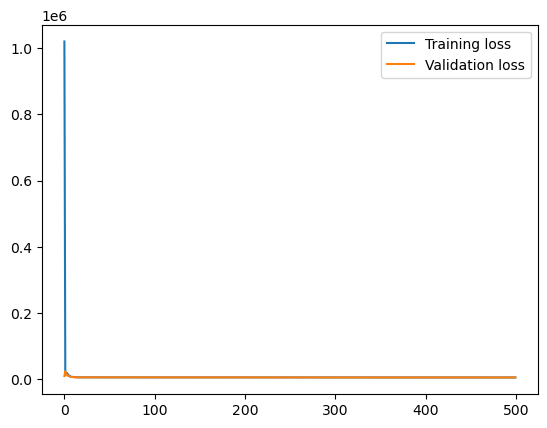

In [134]:
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

num_epochs = 500
all_train_losses = []
all_valid_losses = []

for epoch in range(num_epochs):

    train_losses = []
    valid_losses = []

    model.train()
    for song_features, target_colors in train_loader:
        
        outputs = model(song_features)

        outputs = outputs.view(-1, 10, 3)
        
        loss = criterion(outputs, target_colors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        for val_song_features, val_target_colors in test_loader:
            val_outputs = model(val_song_features)
            val_outputs = val_outputs.view(-1, 10, 3)
            val_loss = criterion(val_outputs, val_target_colors)
            valid_losses.append(val_loss.item())

    all_train_losses.append(np.mean(train_losses))
    all_valid_losses.append(np.mean(valid_losses))

    scheduler.step(np.mean(all_valid_losses))
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]}')

plt.plot(all_train_losses, label='Training loss')
plt.plot(all_valid_losses, label='Validation loss')
plt.legend()
plt.show()


In [135]:
"""
num_epochs = 1000

train_losses = []

for epoch in range(num_epochs):

    for song_features, target_colors in train_loader:
        # Forward pass
        outputs = model(song_features)

        # Flatten the outputs to match the shape of target_colors
        outputs = outputs.view(-1, 10, 3)
        
        # Compute loss
        loss = criterion(outputs, target_colors)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Plot the training loss
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()
"""

"\nnum_epochs = 1000\n\ntrain_losses = []\n\nfor epoch in range(num_epochs):\n\n    for song_features, target_colors in train_loader:\n        # Forward pass\n        outputs = model(song_features)\n\n        # Flatten the outputs to match the shape of target_colors\n        outputs = outputs.view(-1, 10, 3)\n        \n        # Compute loss\n        loss = criterion(outputs, target_colors)\n\n        # Backward pass and optimization\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    train_losses.append(loss.item())\n    if (epoch+1) % 10 == 0:\n        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')\n\n\n# Plot the training loss\nplt.plot(train_losses, label='Training loss')\nplt.legend()\nplt.show()\n"

[[[  7  89 243]
  [ 13  62 168]
  [ 63 107 178]
  [ 63  69  78]
  [231 232 235]
  [127 125 122]
  [162 162 166]
  [248 249 250]
  [193 193 194]
  [212 212 213]]]
(1, 10, 3)


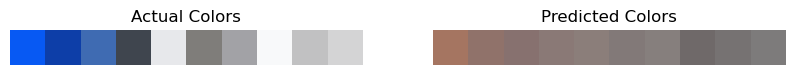

In [138]:
song_idx = 56
song_features, target_colors = test_dataset[song_idx]
song_features = song_features.unsqueeze(0)  # Add batch dimension
predicted_colors = model(song_features)
predicted_colors = predicted_colors.view(-1, 10, 3)


actual_colors = target_colors.detach().numpy()
actual_colors = np.expand_dims(actual_colors, axis=0).astype(int)

predicted_colors = predicted_colors.detach().numpy().astype(int)
print(actual_colors)
print(predicted_colors.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(actual_colors)
axs[0].set_title('Actual Colors')
axs[0].axis('off')
axs[1].imshow(predicted_colors)
axs[1].set_title('Predicted Colors')
axs[1].axis('off')
plt.show()